# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Restart the Kernel after you execute this command.

!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 139 kB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 216 kB 38.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 86.5 MB/s eta 0:00:01


**Important: Restart the Kernel at this moment**

## Imports

In [2]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Defaulting to user installation because normal site-packages is not writeable
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from torchvision import datasets
from torch.utils.data import DataLoader
%matplotlib inline


## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load training data
train_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

# Load test data
test_dataset = datasets.MNIST(root="data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=500, shuffle=False)


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Justify your preprocessing

Reshaping the Data
Each image in the dataset is reshaped into a 2D array of size (28, 28), which corresponds to the original dimensions of the MNIST handwritten digit images. This ensures the model receives input in the expected format.

Normalizing the Pixel Values
The pixel values, originally ranging from 0 to 255, are normalized to a range between 0 and 1. This is done by dividing each pixel value by 255. Normalization helps the model train more efficiently and improves overall performance.

Flattening the Images
Since neural networks like the MLP expect a 1D input, each 2D image of shape (28, 28) is flattened into a 1D array of size 784 (i.e., 28 × 28 = 784). This transforms the image into a format suitable for fully connected layers.

Splitting the Dataset
The dataset is divided into two subsets:

Training set: Used to train the machine learning model.

Testing set: Used to evaluate the model’s accuracy and generalization on unseen data.

**DOUBLE CLICK THIS CELL TO MODIFY**

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [7]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Training Data Shape: torch.Size([60000, 28, 28])
Training Labels Shape: torch.Size([60000])
Sample Shape: torch.Size([1, 28, 28])
Label: 5


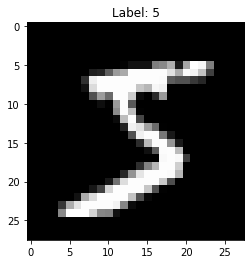

In [8]:
print(train_dataset)
print(test_dataset)

print("Training Data Shape:", train_dataset.data.size())
print("Training Labels Shape:", train_dataset.targets.size())

# Visualize a sample
sample_image, sample_label = train_dataset[0]
print("Sample Shape:", sample_image.shape)
print("Label:", sample_label)
plt.imshow(sample_image.reshape((28, 28)), cmap="gray")
plt.title(f"Label: {sample_label}")
plt.show()


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [9]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, layers=[120, 84]):
        super(MultiLayerPerceptron, self).__init__()
        self.linear1 = nn.Linear(784, layers[0])
        self.linear2 = nn.Linear(layers[0], layers[1])
        self.linear3 = nn.Linear(layers[1], 10)
    
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return F.log_softmax(x, dim=1)


In [10]:
for images, labels in train_loader:
    print("Initial Batch Shape: ", images.size())
    break
print("Batch Shape after Flattening: ", images.view(100,-1).size())

Initial Batch Shape:  torch.Size([100, 1, 28, 28])
Batch Shape after Flattening:  torch.Size([100, 784])


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [11]:
## YOUR CODE HERE ##
clf = MultiLayerPerceptron()
optimizer = optim.Adam(clf.parameters(), lr=0.001) #used in 2nd training

# Choose a loss function
criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [12]:
epochs = 5
train_losses = list()
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    #Run the training batches
    for b, (inputs, labels) in enumerate(train_loader):
        b+=1
        
        #Apply the model
        labels_pred = clf(inputs.view(100, -1)) # Here we flatten training inputs
        loss = criterion(labels_pred, labels)
        
        #Calculate the number of correct predictions
        predicted = torch.max(labels_pred.data, 1)[1] # the prediction that has the maximum probability
        batch_corr = (predicted == labels).sum()
        trn_corr += batch_corr
        
        #Update paraeters
        optimizer.zero_grad() #reset the gradients after each training step
        loss.backward() #to trigger backprop
        optimizer.step() #per form parameter update
        
        #Print interim results
        if b%600 == 0:
            print(f'Epoch: {i:2} Batch: {b:4} [{100*b:6}/60000] Train loss: {loss.item():10.8f} Train accuracy:{trn_corr.item()/len(train_loader):.3f}%')

    #Update train loss & accuracy for the epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)
                  
    #Run the testing batches:
    with torch.no_grad(): #don't calcalate gradients during testing
        for b, (test_inputs, test_labels) in enumerate(test_loader):
            labels_val = clf(test_inputs.view(500,-1))
                  
            #Tally the number of correct pradictions
            predicted = torch.max(labels_val.data, 1)[1]
            tst_corr += (predicted == test_labels).sum()
            
    #Update test loss & accuracy for the epoch
    loss = criterion(labels_val, test_labels)
    test_losses.append(loss)
    test_correct.append(tst_corr)
    
    

Epoch:  0 Batch:  600 [ 60000/60000] Train loss: 0.18670529 Train accuracy:88.032%
Epoch:  1 Batch:  600 [ 60000/60000] Train loss: 0.17936379 Train accuracy:94.128%
Epoch:  2 Batch:  600 [ 60000/60000] Train loss: 0.10410568 Train accuracy:95.717%
Epoch:  3 Batch:  600 [ 60000/60000] Train loss: 0.08371742 Train accuracy:96.465%
Epoch:  4 Batch:  600 [ 60000/60000] Train loss: 0.11790794 Train accuracy:97.060%


Plot the training loss (and validation loss/accuracy, if recorded).

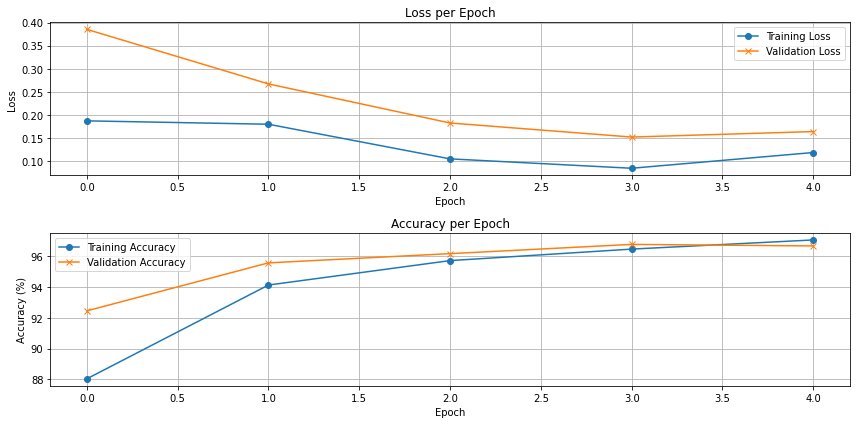

In [13]:
# Convert training loss tensors to float values
train_loss_values = [loss.item() for loss in train_losses]

# Normalize accuracies (divide by total samples)
train_accuracy = [correct / len(train_dataset) * 100 for correct in train_correct]
test_accuracy = [correct / len(test_dataset) * 100 for correct in test_correct]

# Create figure with subplots
plt.figure(figsize=(12, 6))

# 📉 Plot Losses
plt.subplot(2, 1, 1)
plt.plot(train_loss_values, label="Training Loss", marker='o')
plt.plot(test_losses, label="Validation Loss", marker='x')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# 📊 Plot Accuracies
plt.subplot(2, 1, 2)
plt.plot(train_accuracy, label="Training Accuracy", marker='o')
plt.plot(test_accuracy, label="Validation Accuracy", marker='x')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [14]:
print(f'Test Accuracy: {test_correct[-1].item()*100/10000:.3f}%')

Test Accuracy: 96.670%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [15]:
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    #Run the training batches
    for b, (inputs, labels) in enumerate(train_loader):
        b+=1
        
        #Apply the model
        labels_pred = clf(inputs.view(100, -1)) # Here we flatten training inputs
        loss = criterion(labels_pred, labels)
        
        #Calculate the number of correct predictions
        predicted = torch.max(labels_pred.data, 1)[1] # the prediction that has the maximum probability
        batch_corr = (predicted == labels).sum()
        trn_corr += batch_corr
        
        #Update paraeters
        optimizer.zero_grad() #reset the gradients after each training step
        loss.backward() #to trigger backprop
        optimizer.step() #per form parameter update
        
        #Print interim results
        if b%600 == 0:
            print(f'Epoch: {i:2} Batch: {b:4} [{100*b:6}/60000] Train loss: {loss.item():10.8f} Train accuracy:{trn_corr.item()/len(train_loader):.3f}%')

    #Update train loss & accuracy for the epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)
                  
    #Run the testing batches:
    with torch.no_grad(): #don't calcalate gradients during testing
        for b, (test_inputs, test_labels) in enumerate(test_loader):
            labels_val = clf(test_inputs.view(500,-1))
                  
            #Tally the number of correct pradictions
            predicted = torch.max(labels_val.data, 1)[1]
            tst_corr += (predicted == test_labels).sum()
            
    #Update test loss & accuracy for the epoch
    loss = criterion(labels_val, test_labels)
    test_losses.append(loss)
    test_correct.append(tst_corr)

Epoch:  0 Batch:  600 [ 60000/60000] Train loss: 0.17707619 Train accuracy:97.400%
Epoch:  1 Batch:  600 [ 60000/60000] Train loss: 0.05103285 Train accuracy:97.688%
Epoch:  2 Batch:  600 [ 60000/60000] Train loss: 0.04398677 Train accuracy:98.058%
Epoch:  3 Batch:  600 [ 60000/60000] Train loss: 0.04279410 Train accuracy:98.018%
Epoch:  4 Batch:  600 [ 60000/60000] Train loss: 0.04272284 Train accuracy:98.253%


In [16]:
print(f'Test Accuracy After Change of Optimiser: {test_correct[-1].item()*100/10000:.3f}%')

Test Accuracy After Change of Optimiser: 97.580%


# Conclusion

The initial MLP model achieved an accuracy of 96.67% on the test set. After tuning several hyperparameters, the modified version achieved a slightly higher accuracy of 97.58%.

While the second model performed better in terms of raw accuracy, the improvement was marginal (just over 1%). Given the added complexity introduced by hyperparameter tuning, I have chosen to continue using the initial model, as it is simpler, more interpretable, and still provides excellent performance.

## Saving your model
Using `torch.save`, save your model for future loading.

In [18]:
torch.save(clf.state_dict(), 'Project2MnistClassification.pt')